# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression of climatological fields with eddy decomposition on OMET with spatial patterns in certain season** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.10.30 ** <br>
** Last Update  : 2018.10.30 ** <br>
Description     : This notebook includes the result of the lag regression of climatological fields (e.g. z500) on OMET. It aims to unveil the relation between the climatological fields and OMET and try to illustrate how the ocean drives the atmosphere through the change of OMET.
Besides, the contribution of stationary eddy and steady mean transport are studied here too.<br>
Return Values   : jpeg <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/yang/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2014
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [10]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_ORAS4_mask = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ORAS4'
    output_path = '/home/yang/NLeSC/PhD/Paperwork/Article/Atmos_Feedback/figures/OMET'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_z500hPa_eddy = Dataset(os.path.join(datapath_ERAI_fields,
                                        'pressure_erai_subdaily_075_z500_eddies_point.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                 'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 4D fields [year, month, lat, lon]
    # geopotential height at 500hPa (m)
    z500_transient = dataset_ERAI_z500hPa_eddy.variables['transient'][:-1,:,:,:]
    z500_standing = dataset_ERAI_z500hPa_eddy.variables['standing'][:-1,:,:,:]
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:-1,:,180:]/1000
    OMET_atl_100_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_100_int'][21:-1,:,180:]/1000
    OMET_atl_300_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_300_int'][21:-1,:,180:]/1000
    OMET_atl_700_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_700_int'][21:-1,:,180:]/1000
    OMET_atl_2000_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_2000_int'][21:-1,:,180:]/1000
    
    OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:-1,:,180:]/1000  
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    gphiv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['gphiv'][180:,:]
    glamv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['glamv'][180:,:]
    latitude_eddy_ERAI = dataset_ERAI_z500hPa_eddy.variables['latitude'][:]
    longitude_eddy_ERAI = dataset_ERAI_z500hPa_eddy.variables['longitude'][:]
    mask_ORAS4 = dataset_ORAS4_mask.variables['vmask'][0,0,180:,:]
    # area weighted surface flux
    z500_transient_weight = np.zeros(z500_transient.shape, dtype=float) # unit W
    z500_standing_weight = np.zeros(z500_standing.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_eddy_ERAI /
                                            360) / len(longitude_eddy_ERAI) 
    for i in np.arange(len(latitude_eddy_ERAI)):
        # change the unit to terawatt
        z500_transient_weight[:,:,i,:] = z500_transient[:,:,i,:]* dx[i] / dx[-1]
        z500_standing_weight[:,:,i,:] = z500_standing[:,:,i,:]* dx[i] / dx[-1]

*********************** extract variables *************************


Table for an easy lead / lag analysis of seasonal data <br>

| -6 | -5 | -4 | -3 | -2 | -1 |winter| +1 | +2 | +3 | +4 | +5 | +6 |
|----|----|----|----|----|----|------|----|----|----|----|----|----|
|JJA |JAS |ASO |SON |OND |NDJ |DJF   |JFM |FMA |MAM |AMJ |MJJ |JJA |

| -6 | -5 | -4 | -3 | -2 | -1 |summer| +1 | +2 | +3 | +4 | +5 | +6 |
|----|----|----|----|----|----|------|----|----|----|----|----|----|
|DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |JAS |ASO |SON |OND |NDJ |DJF |

In [4]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! The definition of lead/lag is the opposite to the one defined in the package.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z500 eddy transient + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


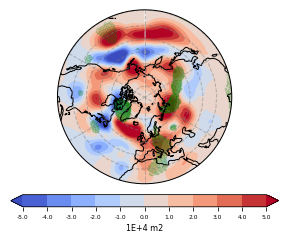

[[ 9306.66733016  9162.555165    9014.65992485  8864.68346282
   8713.4353329   8559.62516848  8406.69749852  8250.48588691
   8093.67828798  7937.19398757]
 [10285.40218515 10111.66972476  9933.53366328  9751.55128117
   9571.46083205  9381.53224055  9193.0942029   9000.17020174
   8807.50168575  8613.5906296 ]
 [11124.19577677 10919.34489651 10705.56130532 10491.12001604
  10275.02332608 10051.41877244  9826.95217825  9603.72552763
   9373.78316304  9142.19496172]
 [11716.58956673 11473.61097343 11230.25775036 10981.73657893
  10725.50111422 10469.45368067 10207.807942    9945.80430497
   9680.22172174  9414.59179071]
 [12055.97784434 11771.45747615 11479.13243263 11185.0582327
  10888.92189581 10588.07397783 10288.7981115   9987.84111247
   9680.07682534  9377.66870251]
 [12187.70243713 11850.30247997 11508.53082423 11163.59450666
  10821.07860928 10472.3028487  10129.99749915  9778.28689251
   9433.06170897  9087.49650483]
 [12242.63681851 11859.90901243 11467.4395464  11071.341242

In [13]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & z500 eddy transient + winter (DJF)   ===================')
    lag = 2
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    z500_eddy_season_series = meta.statistics.operator.seasons(z500_transient_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_z500_eddy_ERAI = meta.statistics.operator(z500_eddy_season_series[3:,:,:])
    stat_z500_eddy_ERAI.anomaly(Dim_month=False)
    stat_z500_eddy_ERAI.detrend()
    stat_z500_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_z500_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_z500_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_z500_eddy_transient_DJF_decadal.png'.format(lag)),
                                   ttest=True)
    print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z500 eddy standing + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


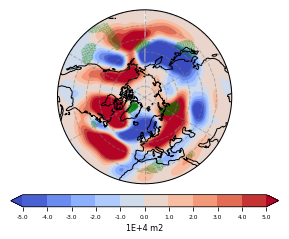

[[2368.11240363 2331.00089564 2289.11523702 2244.88404373 2196.72563521
  2146.51809417 2092.91952239 2035.31853941 1975.54920924 1912.51267655]
 [2369.50536824 2337.84799772 2300.63589744 2260.41078149 2216.20533658
  2163.32630036 2107.44813771 2045.47820779 1980.1634155  1908.2621501 ]
 [2228.93795128 2206.78784192 2174.49002256 2140.25980914 2099.10307509
  2050.58609411 1996.53561967 1939.36928966 1873.61767562 1804.52858762]
 [1971.71298433 1961.74291494 1948.54511673 1926.1074499  1896.59570267
  1862.34530874 1819.54667594 1772.90971207 1716.92469782 1654.58543451]
 [1789.10937254 1791.75140952 1785.65714442 1775.37557515 1757.81900853
  1727.63798427 1693.94533345 1651.93730541 1594.27404943 1533.94461277]
 [1907.6711236  1909.3014342  1899.76168465 1883.96248011 1866.74351483
  1838.6819997  1804.74049214 1759.26560812 1709.90264072 1653.37039654]
 [2538.41615905 2538.17238666 2524.51434567 2500.95358131 2482.77921441
  2449.4683966  2410.52778465 2370.37852797 2324.09297447 

In [14]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & z500 eddy standing + winter (DJF)   ===================')
    lag = 2
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    z500_eddy_season_series = meta.statistics.operator.seasons(z500_standing_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_z500_eddy_ERAI = meta.statistics.operator(z500_eddy_season_series[3:,:,:])
    stat_z500_eddy_ERAI.anomaly(Dim_month=False)
    stat_z500_eddy_ERAI.detrend()
    stat_z500_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_z500_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_z500_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    #label = 'Correlation coefficient'
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_z500_eddy_standing_DJF_decadal.png'.format(lag)),
                                   ttest=True)
    print (k[10:20,30:40])